# Admin

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit

import importlib

import Calibration_Function_V2 as CF2
import Calibration_Function as CF

importlib.reload(CF2)
importlib.reload(CF)

<module 'Calibration_Function' from 'C:\\Users\\sebas\\PycharmProjects\\Advanced-Lab-Code\\Monochromator_Calibration\\Calibration_Function.py'>

In [64]:
# Data Processing


#Note: we have swapped to a different monochromator as there were issues with the original
wavelengths = np.array([632.8,  #Red
               594.1,  #Orange
               543.5,  #Green
               ])

start_indexes = [9732,  #Red
                 9693,  #Orange
                 9641,  #Green
                 ]

sheets = ['Red',
          'Orange',
          'Green'
          ]

cols = [
    ['R_A_0', 'R_A_1', 'R_A_2', 'R_A_3', 'R_A_4'], #Red
    ['O_A_0', 'O_A_1', 'O_A_2', 'O_A_3', 'O_A_4', 'O_A_5'],  # Orange
    ['G_A_0', 'G_A_1', 'G_A_2', 'G_A_3', 'G_A_4']  #Green
]
file = "Calibration_Runs_2.xlsx"

In [65]:
def chi_squared(model, model_params, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params)) / y_error)**2)

def reduced_chi_squared(Chi_squared, DoF):
    return Chi_squared / (DoF)

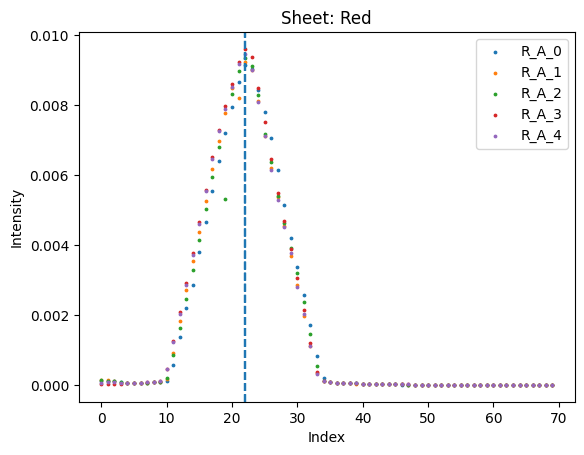

----- Results -----
Sheet 'Red': mean peak index = 22.0 ± 0.0
Standard deviation of the mean is 0.0
----- ----- -----


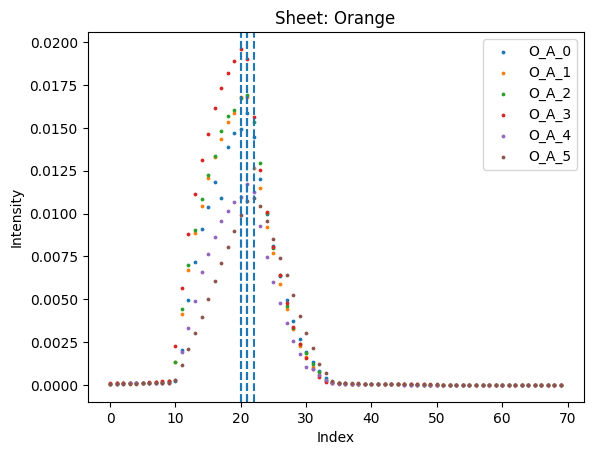

----- Results -----
Sheet 'Orange': mean peak index = 20.833333333333332 ± 0.28054180384339106
Standard deviation of the mean is 0.6871842709362768
----- ----- -----


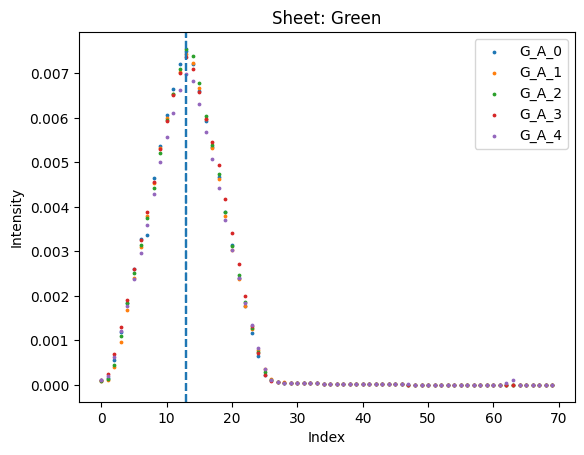

----- Results -----
Sheet 'Green': mean peak index = 13.0 ± 0.0
Standard deviation of the mean is 0.0
----- ----- -----


([np.float64(22.0), np.float64(20.833333333333332), np.float64(13.0)],
 [np.float64(0.0), np.float64(0.28054180384339106), np.float64(0.0)])

In [72]:
CF.Calibration_Index(file_name= file, sheet_names=sheets, column_names=cols)

# Peak Extraction

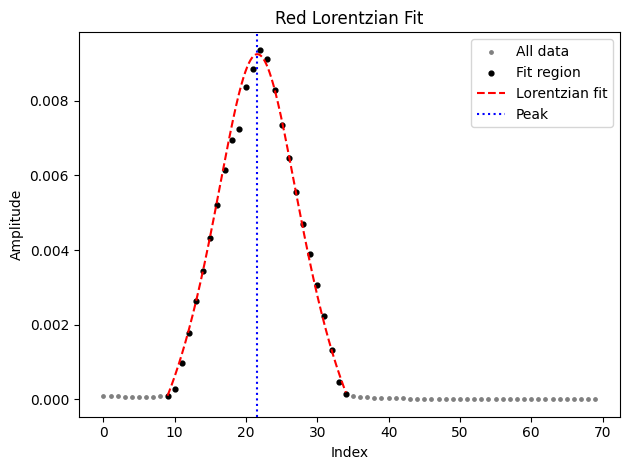

 ---- Results ---- 
Sheet: Red
Peak index = 21.593 ± 0.041
Width B = 8.92
Reduced χ² = 0.923
Amplitude cutoff = 1.0% of A_max
----- ----- -----



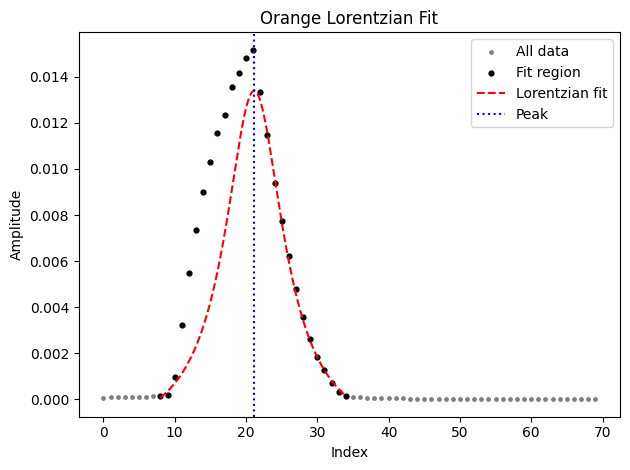

 ---- Results ---- 
Sheet: Orange
Peak index = 21.147 ± 0.091
Width B = 5.00
Reduced χ² = 1.774
Amplitude cutoff = 1.0% of A_max
----- ----- -----



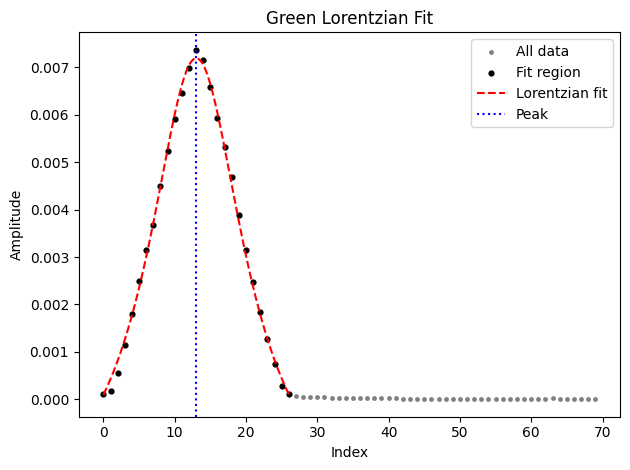

 ---- Results ---- 
Sheet: Green
Peak index = 13.021 ± 0.021
Width B = 8.20
Reduced χ² = 2.020
Amplitude cutoff = 1.0% of A_max
----- ----- -----



In [46]:
# all at once (if the noise is acceptable)
results, res_err = CF2.peak_extractor(
    file=file,
    sheets=sheets,
    cols=cols,
    amplitude_frac=0.01,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)



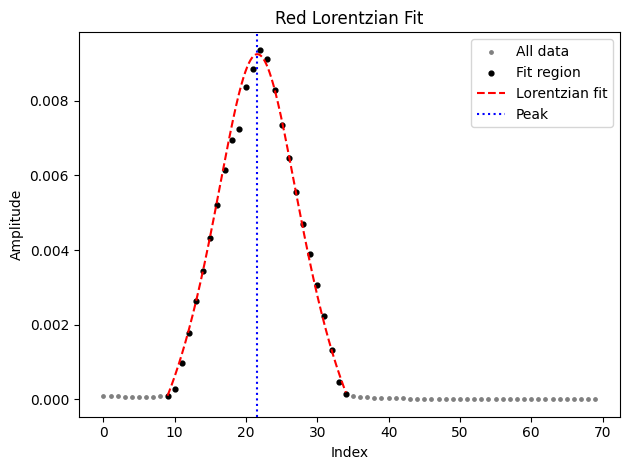

 ---- Results ---- 
Sheet: Red
Peak index = 21.593 ± 0.041
Width B = 8.92
Reduced χ² = 0.923
Amplitude cutoff = 1.0% of A_max
----- ----- -----



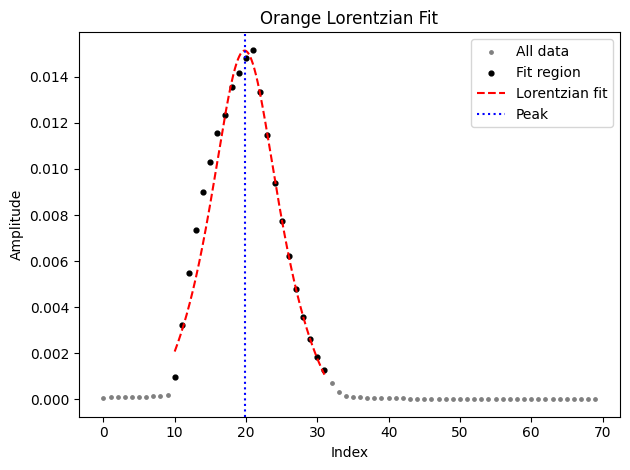

 ---- Results ---- 
Sheet: Orange
Peak index = 19.808 ± 0.310
Width B = 6.53
Reduced χ² = 0.214
Amplitude cutoff = 5.0% of A_max
----- ----- -----



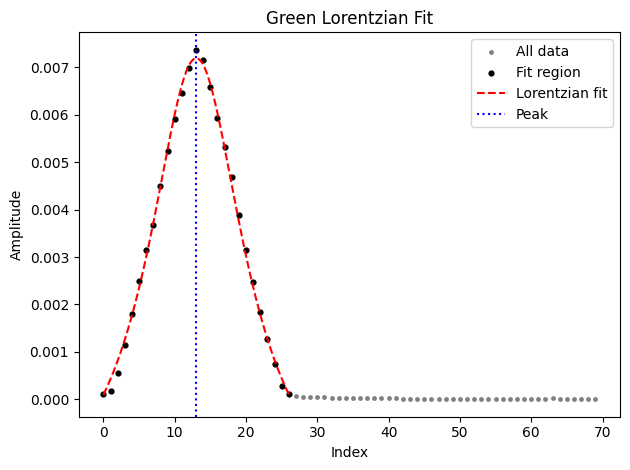

 ---- Results ---- 
Sheet: Green
Peak index = 13.021 ± 0.021
Width B = 8.20
Reduced χ² = 2.020
Amplitude cutoff = 1.0% of A_max
----- ----- -----



In [47]:
#individually (if noise is unacceptable)

results_red, red_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[0],
    cols=cols[0],
    amplitude_frac=0.01,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

results_orange, orange_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[1],
    cols=cols[1],
    amplitude_frac=0.05,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

results_green, green_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[2],
    cols=cols[2],
    amplitude_frac=0.01,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

# Model Fitting

In [48]:
results = np.concatenate((results_red, results_orange, results_green))
results_err = np.concatenate((red_err, orange_err, green_err))


def line(x, A, B):
    return x * A + B


p0_line = [1, 1]

indexes = start_indexes - 0.1 * results
indexes_error = np.abs((start_indexes - 0.1 * (results + results_err)) - (start_indexes - 0.1 * results))

print(results_err)
print(indexes_error)

popt_line, cov_line = curve_fit(line,
                                xdata=wavelengths,
                                ydata=indexes,
                                sigma=indexes_error,
                                absolute_sigma=True,
                                p0=p0_line)

dof_line = len(wavelengths) - len(popt_line)

chi2 = chi_squared(model=line,
                   model_params=popt_line,
                   x_data=wavelengths,
                   y_data=indexes,
                   y_error=indexes_error
                   )

Rchi2 = reduced_chi_squared(chi2, DoF=dof_line)

[0.04073925 0.31038067 0.0210118 ]
[0.00407393 0.03103807 0.00210118]


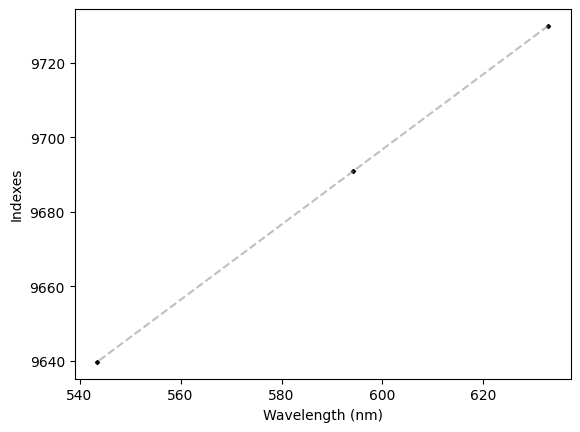

----- Results -----
Gradient is 1.0095 ± 0.0001
Intercept is 9091.0570 ± 0.0289
Reduced chi_squared is 61.2806
----- ----- -----


In [57]:
plt.figure(1)

plt.scatter(wavelengths, indexes, marker="D", color='black', s=4)
plt.plot(wavelengths, line(wavelengths, popt_line[0], popt_line[1]), color="grey", linestyle= "--", alpha=0.5)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Indexes")
plt.show()

print(f"----- Results -----")
print(f"Gradient is {popt_line[0]:.4f} ± {np.sqrt(cov_line[0, 0]):.4f}")
print(f"Intercept is {popt_line[1]:.4f} ± {np.sqrt(cov_line[1, 1]):.4f}")
print(f"Reduced chi_squared is {Rchi2:.4f}")
print("----- ----- -----")

In [50]:
print(indexes)

[9729.84074325 9691.01921558 9639.69787348]
